In [1]:
using Pkg
using JLD
using Plots, LaTeXStrings
using LinearAlgebra
using DifferentialEquations
using Plots.PlotMeasures

\begin{equation}
    \left\lbrace \begin{array}{lllll}
    \dot{x}(t) &= \big(M(s(t))-uI_n+\varepsilon Z\big)x(t), \\ \\
     \dot{s}(t) &= - \displaystyle\sum_{j=1}^n\frac{ \mu_j(s(t))x_j(t)}{Y_j}+ u(s_{in}-s(t)).
    \end{array} \right.
\end{equation}

## Model analysis

**Parameters:**

In [2]:
n = 5 

a = [i for i in 1:n] 
b = [i^2 for i in 1:n]  

Y = ones(n)
s_in = 35.0

d = [-1; [-2 for i in 1:(n-2)]; -1]
d1 = [1 for i in 1:(n-1)]
matrix_Z = SymTridiagonal(d, d1);

In [3]:
# import functions of the model
include("functions.jl");

**Simulation of the kinetics $\mu_i(s)$**

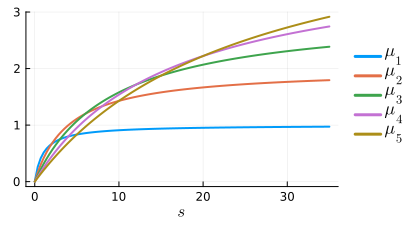

In [4]:
Ns = 100
s_vector = range(0, stop=s_in, length=Ns)
mu_labels = [L"\mu_%$i" for i in 1:n]
mu_values =  [ [μ(s,i) for s in s_vector] for i in 1:n ];
label = reshape(mu_labels[1:n],(1,:))
p = plot(s_vector, mu_values, label=label, lw=2, size=(420, 225),
        legendfont = font(12), xlabel=L"s",grid=true, 
        background_color_legend="white",fg_legend = :false, 
        legend=:outerright)

**Simulation of a solution to (1)**

In [8]:
u = 1.5
ε = 0.01
θ = 0.01

y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n

tf = 120.0
auto = 1
sol = solvePCS(f,y0,tf,u,ε,auto);

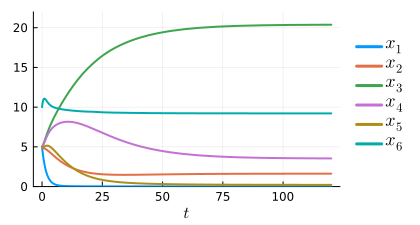

In [9]:
x_labels = permutedims([L"x_%$i" for i in 1:n+1])
p = plot(sol.t, transpose(sol[:,:]), label=x_labels, lw=2, size=(420, 225),
        legendfont = font(12), xlabel=L"t",grid=true, background_color_legend="transparent", 
        legend=:outerright, fg_legend = :false, ylimits=(0,22))

## Stability analysis

**Computation of the steady states**

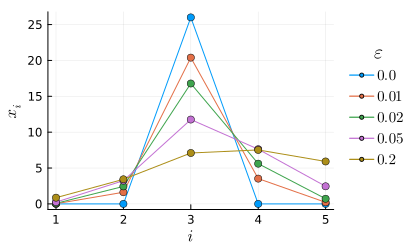

In [10]:
u = 1.5
y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n
tf = 1e5; # large final time to reach the steady state
tol_s_state = 1e-10 # tolerance for the steady dynamics

ε_list = [0.0, 0.01, 0.02, 0.05, 0.2]
Matrix_ss_ε = Array{Float64}(undef, length(ε_list), n) 
auto = true

for (j,ε) in pairs(ε_list)
    sol = solvePCS(f,y0,tf,u,ε,auto); # solve the ode
    x_s, s_s = sol[1:n,end],  sol[n+1,end] # recover the steady states
    Matrix_ss_ε[j,:] = x_s
    # confirm that the dynamics at the steady state are zero
    error_s_state = sum([((μ(s_s,i) - u) * x_s[i]) + M(ε,x_s,s_s,i) for i in 1:n])+dS(x_s, s_s, u)
    if error_s_state>tol_s_state
        println(ε)
    end
end

index = [i for i in 1:n]
ε_labels = [ L"%$e" for e in ε_list]
label = reshape(ε_labels,(1,:))
p = plot(index, transpose(Matrix_ss_ε), marker=(:circle,4), label=label, 
        lw=1, size=(420, 250),legendfont = font(10), xlabel=L"i", ylabel=L"x_i",
        grid=true, legend=:outerright, legend_title=L"\varepsilon",legendtitlefontsize = 13,
        background_color_legend="white",fg_legend = :false)


**Robustness with respect to the initial condition**

_We compute $x^*(u,\varepsilon,\theta)$ steady states of (1) for different values of $x(0)$ and $s(0)$ and check if it vary. We take randomly 100 initial conditions in the set $(0,100]^n \times [0,{s_i}_n]$. We exclude the case $x(0)=0$ as we know it leads to washout._

In [8]:
u = 1.5
ε = 0.01
θ = 0.01
tf = 1e5 # large final time to reach the steady state
tol_s_state = 1e-10 # tolerance for the steady dynamics
tol_robustness = 1e-8 # tolerance for robustness (difference between steady states)
len = 1000 # number of initial conditions to test

# compute example steady state
y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n
auto = true
sol = solvePCS(f,y0,tf,u,ε,auto) # solve the ode
y_s = sol[:,end] # recover the steady states y=(x,s)

for k in 1:len
    # find a random inital condition
    x0 = rand(1e-3:100, n) 
    s0 = rand(0:s_in, 1) 
    y0 = vcat(x0,s0)
    # compute the steady state 
    sol = solvePCS(f,y0,tf,u,ε,auto) # solve the ode
    y = sol[:,end] # recover the steady states
    if norm(y-y_s)>tol_robustness
        println(y0)
    end
end

## Optimization analysis

\begin{equation}
\tag{2}
    \left\lbrace \begin{array}{lllll}
    &\displaystyle\min_{u(\cdot)\in [0, u_{\max}]} \ \ J(u)  
    \\
    \\
    \text{s.t.}&\\
    &0 = \big(M(s)-uI_n+\varepsilon Z\big)x , \\
    \\
       & 0 = - \displaystyle\sum_{j=1}^n\frac{ \mu_j(s)x_j}{Y_j}+ u(s_{in}-s),\\
    \\
      &S(x)  \leq \alpha,
    \end{array}
    \right.
\end{equation}


* Model 1 :

  *  $ J(u):=- P\big(x,u\big)  $

  * $ S(x) \ \leq \ \alpha$

* Model 2 :

  *  $ J(u):= S(x(t)) $

  * $P\big(x,u\big) \ \geq \ \beta$

**Computation of steady states $x^*$ and $P(x^*,u^*)$, $S(x^*)$, for different values of $u$** 

In [24]:
ε = 0.01
θ = 0.02
y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n
tf = 1e5  # large final time to reach the steady state
tol_s_state = 1e-10 # tolerance for the steady dynamics


len = 1000 # u grid size 
u_max = 3
u_list = range(0, stop=u_max, length=len)
x_list = Array{Float64}(undef, len, n)
Sx_list, Px_list = zeros(len), zeros(len)

for (k,u) in pairs(u_list)
    # compute the steady state
    auto = 1
    sol = solvePCS(f,y0,tf,u,ε,auto)
    x = sol[1:n,end]
    # save the value of x^* and S(x^*), P(x^*,u^*)
    x_list[k,:], Sx_list[k], Px_list[k],  = x, S_func(x), P_func(u,x)
    # confirm that the dynamics are the steady state are zero
    s = sol[n+1,end]
    error_s_state = sum([((μ(s,i) - u) * x[i]) + M(ε,x,s,i) for i in 1:n])+dS(x, s, u)
    if error_s_state>tol_s_state
        println(u)
    end
end;

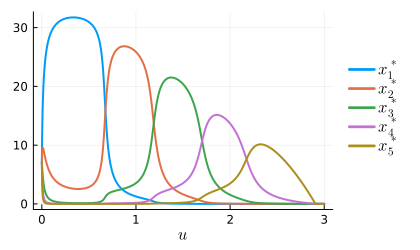

In [13]:
x_labels = permutedims([L"x^*_%$i" for i in 1:n+1])
p = plot(u_list, x_list, label=x_labels, lw=2, size=(420, 250),
        legendfont = font(11), xlabel=L"u",grid=true, 
        background_color_legend="transparent", 
        legend=:outerright, fg_legend = :false)

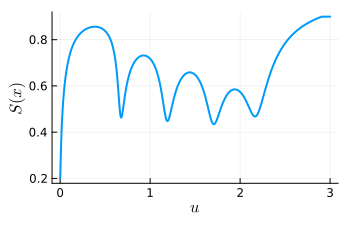

In [14]:
p = plot(u_list,Sx_list, lw=2, xlabel=L"u", ylabel=L"S(x)",
        size=(350, 225),legend=false)

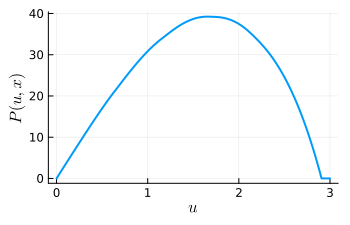

In [15]:
p = plot(u_list,Px_list, lw=2, xlabel=L"u", ylabel=L"P(u,x)",
        size=(350, 225),legend=false)

In [25]:
function get_optimal_u(model,c)
    if model == 1
        J_u = Px_list
        constr = Sx_list
    
    elseif model == 2
        J_u = Sx_list
        constr = -Px_list
    end
    index_u_max = 0
    J_max = 0.0 
    
    # find the u value that fullfils S(T)≤u_max and maximizes P(x,u)
    for (k,constr_k) in pairs(constr)
        if constr_k <= c
            J_u_k = J_u[k]
            if J_u_k > J_max
                index_u_max = k
                J_max = J_u_k
            end 
        end
    end 
    return index_u_max
end;

function get_solution(u, auto)
    # save the results
    sol = solvePCS(f,y0,tf,u,e,auto); # simulate the trajectories 
    t, x  = sol.t, sol[1:n,:];
    J, S = 0, 0
    for k in 1:(length(t)-1)
        J += (t[k+1]-t[k])*(P_func(u,x[:,k])+P_func(u,x[:,k+1]))/2
        S += (t[k+1]-t[k])*(S_func(x[:,k])+S_func(x[:,k+1]))/2
    end
    return t, x, J, S
end;

**Find the solution to (2) by extensive search for different values of $\alpha$**

In [17]:
model = 1
e = 0.01
y0 = 5*ones(n+1)
y0[n+1] = s_in-5*n
tf = 75.0

α_min = 1/n 
α_max = 1.0
len = 40 # α grid size
α_list = range(α_min, α_max, len)
OF_static = Array{Float64}(undef, len, 3) # array to save [J(u),S(x(T)),α]

if model == 1
    c_list = range(1/n, 1, len) #(min,max,len)
elseif model == 2
    c_list = -range(0, maximum(Px_list), len) #(min,max,len)
end

for i in 1:len
    c = c_list[i]
    index_u_max = get_optimal_u(model, c) 

    # save the results
    if index_u_max > 0 # this means that there is a feasible solution
        u = u_list[index_u_max]
        auto = 1 # 1 for autonomous (u constant), 0 for v(t)
        t, x, J, S = get_solution(u, auto)
    else
        J, S = NaN, NaN
    end
    OF_static[i,:] = [J, S, abs(c)]
end

In [28]:
# model = 1
# e = 0.01
# y0 = 5*ones(n+1)
# y0[n+1] = s_in-5*n
# tf = 75.0

# α_min = 1/n 
# α_max = 1.0
# len = 40 # α grid size
# α_list = range(α_min, α_max, len)
# OF_static = Array{Float64}(undef, len, 3) # array to save [J(u),S(x(T)),α]

# if model == 1
#     J_u = Px_list
#     constr = Sx_list
#     c_list = range(1/n, 1, len) #(min,max,len)


# elseif model == 2
#     J_u = Sx_list
#     constr = -Px_list
#     c_list = -range(0, maximum(Px_list), len) #(min,max,len)
# end

# for i in 1:len
#     c = c_list[i]
#     index_u_max = 0
#     J_max = 0.0 

#     # find the u value that fullfils S(T)≤u_max and maximizes P(x,u)
#     for (k,constr_k) in pairs(constr)
#         if constr_k <= c
#             J_u_k = J_u[k]
#             if J_u_k > J_max
#                 index_u_max = k
#                 J_max = J_u_k
#             end 
#         end
#     end 

#     # save the results
#     if index_u_max > 0 # this means that there is a feasible solution
#         u = u_list[index_u_max]
#         sol = solvePCS(f,y0,tf,u,e); # simulate the trajectories 
#         t, x  = sol.t, sol[1:n,:];
#         J, S = 0, 0
#         for k in 1:(length(t)-1)
#             J += (t[k+1]-t[k])*(P_func(u,x[:,k])+P_func(u,x[:,k+1]))/2
#             S += (t[k+1]-t[k])*(S_func(x[:,k])+S_func(x[:,k+1]))/2
#         end
#     else
#         J, S = NaN, NaN
#     end
#     OF_static[i,:] = [J, S, abs(c)]
# end

In [72]:
# load the dynamic optimization results to compare
OF_dynamic = load("output/model 1/sol_dyn2.jld")["OF_list"] ;

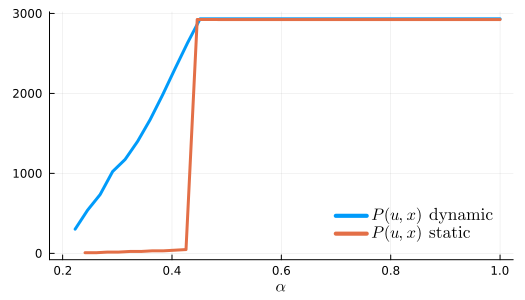

In [73]:
x_1 = OF_dynamic[:,3]
x_2 = OF_static[:,3]

y_1 = OF_dynamic[:,1]
y_2 = OF_static[:,1]
p = plot( [x_1,x_2], [y_1,y_2], lw=3, xlabel=L"\alpha" , 
            label=[L"P(u,x)"*" dynamic" L"P(u,x)"*" static"],
            fg_legend = :false,#ylimits=(00,3000), 
            size=(525,300), left_margin = 1mm, 
            background_color_legend="transparent",
            legendfont = font(11,"Computer Modern"))

# y_1 = OF_dynamic[:,2]
# y_2 = OF_static[:,2]
# p = plot( [x_1,x_2], [y_1,y_2], lw=3, xlabel=L"\beta" , 
#             label=[L"S(x)"*" dynamic" L"S(x)"*" static"],
#             fg_legend = :false,#ylimits=(00,3000), 
#             size=(525,300), left_margin = 1mm, 
#             background_color_legend="transparent",
#             legendfont = font(11,"Computer Modern"))

In [74]:
savefig(p, "output/model 1/comp2.pdf")

"/Users/claudiaalvarez/Documents/github/Numeric OCP/output/model 1/comp2.pdf"

In [36]:
OF_static

40×3 Matrix{Float64}:
  NaN      NaN       0.2
  NaN      NaN       0.220513
  NaN      NaN       0.241026
  NaN      NaN       0.261538
  NaN      NaN       0.282051
  NaN      NaN       0.302564
  NaN      NaN       0.323077
   26.305   15.8691  0.34359
   26.305   15.8691  0.364103
   26.305   15.8691  0.384615
   26.305   15.8691  0.405128
   26.305   15.8691  0.425641
 2924.63    29.9018  0.446154
    ⋮                
 2923.67    30.6461  0.774359
 2923.67    30.6461  0.794872
 2923.67    30.6461  0.815385
 2923.67    30.6461  0.835897
 2923.67    30.6461  0.85641
 2923.67    30.6461  0.876923
 2923.67    30.6461  0.897436
 2923.67    30.6461  0.917949
 2923.67    30.6461  0.938462
 2923.67    30.6461  0.958974
 2923.67    30.6461  0.979487
 2923.67    30.6461  1.0

___

Comparison for $u^*(\alpha=0.4)$ and $u^*(\alpha=0.5)$

Performance of a constant control $u=u^*$ and the oscilation $u(t)=u^*+\delta_u\cos\big(2\pi\theta\frac{t}{T}\big)$

In [101]:
model   = 1
e       = 0.01
y0      = 5*ones(n+1)
y0[n+1] = s_in-5*n
tf      = 75.0
c       = 0.43

index_u_max = get_optimal_u(model, c) 

if index_u_max > 0 # this means that there is a feasible solution
    u = u_list[index_u_max]
    auto = 1 # 1 for autonomous (u constant), 0 for v(t)
    t, x, J, S = get_solution(u, auto)
    print("u=",u,"\n","P=",J,"\n","S=",S)
else
    print("unfeasible")
end;

u=0.018018018018018018
P=47.22013129933191
S=17.538133445830137

Finding a combination of $\delta_u$ and $\theta$ that minimize $S$

In [138]:
T   = 75
# o   = 5 # number of osilations
# d_u = u/2 # amplitud of variation

#find θ∈(1,20) takes minimized S
auto = 0
len  = 20

m = 1 # mu* instead of u* for small values (displacement of u*)

d_min, o_min = 0, 0 
S_min = 100
for d_u in range(0, min(u_max-m*u, m*u), len)
    S_curr = 100
    o_curr = 0
    for o in 1:len
        function v(t,u)
            # return u+d_u*cos(2*π*o*t/T)
            return m*u+d_u*cos(2*π*o*t/T)
        end;
        _, _, _, S = get_solution(u, auto)
        if S < S_curr 
            o_curr = o
            S_curr = S 
        end
    end
    if S_curr < S_min
        d_min, o_min = d_u, o_curr
        S_min = S_curr
    end
end

In [139]:
d_min, o_min

(0.018018018018018018, 1)

In [140]:
o = o_min
d_u = d_min 
function v(t,u)
    return m*u+d_u*cos(2*π*o*t/T)
end; 
_, _, J, S  = get_solution(u, 0)
J,S

(47.21893988150049, 17.119383966801298)


|$c$|$\delta_i$|$\theta$|$P$|$S$|
|--------|-------|-------|-------|-------|
|1|-|-|2923|30.67|
|1 |0.61|17|2841|29.336|
|
| 0.45| -| -| 2924 |29.958 |
| 0.45| 0.442| 16| 2883 |29.575 |
|
| 0.43| -| -| 47.22 | 17.53 |
| 0.43|0.018 | 1 | 47.218 |17.119 |
|

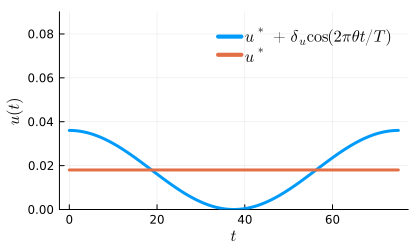

In [143]:
o = o_min
d_u = d_min 
function v(t,u)
        return m*u+d_u*cos(2*π*o*t/T)
end; 

t_vector = range(0, stop=T, length=1000)
v_values = [v(t,u) for t in t_vector];
u_values = [u for t in t_vector];
p = plot(t_vector,v_values, lw=2, xlabel=L"t", ylabel=L"u(t)",
        ylimits=(0,min(3*u,3)), size=(525,300),legend=false)


p = plot( [t_vector,t_vector], [v_values,u_values], lw=3, xlabel=L"t" , ylabel=L"u(t)",
        label=[L"u^*+\delta_u\cos(2\pi\theta t/T)" L"u^*"],
        fg_legend = :false,#ylimits=(00,3000), 
        size=(420,250), left_margin = 1mm, 
        background_color_legend="transparent",ylimits=(0,min(5*u,3)),#min(3*u,3)
        legendfont = font(11,"Computer Modern"))

In [144]:
savefig(p, "output/model 1/oscilation_c=0-43.pdf")

"/Users/claudiaalvarez/Documents/github/Numeric OCP/output/model 1/oscilation_c=0-43.pdf"